# BIOS-584 Final Project Part 2: Statistical Analysis Plan

### Rebecca McSweeney
### November 14, 2025

This Jupyter notebook outlines the proposed analyses I aim to perform in my final project for BIOS-584. I aim to analyze short-read RNA sequencing data from an experiment from my lab, which analyzed the effects of loss of the highly conserved RNA binding protein Nab2/ZC3H14<sup>1</sup>.

First, I will import the following packages:

In [261]:
import numpy as np
import scipy
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression 

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

## Steps for Initial Analysis:
1. Download raw RNA sequencing files (completed 11-13-25)
2. Map to assembled and annotated reference genome (performed using the RNA Star Platform in Galaxy as described here<sup>1</sup>.
3. Calculate the intron retention score (see below)
4. Determine whether this ratio is consistent with the presence of an intron retention event.
5. Classify transcripts based on their intron retention status and location of the retained intron.
6. Analyze summary statistics for the variables covered in this study.

In [262]:
# Read counts and lengths for 5' UTR
length_5_UTR_df = pd.read_csv("data/{}_Feature_lengths.csv".format("5'_UTR"),names=["Gene Name", "5' UTR Length (nt)"]) 
length_5_UTR_df.head() 

counts_5_UTR_df = pd.read_csv("data/{}_Counts.csv".format("5'_UTR"),names=["Gene Name", "5' UTR Counts"]) 
counts_5_UTR_df.head()

# Read counts and lengths for 3' UTR
length_3_UTR_df = pd.read_csv("data/{}_Feature_lengths.csv".format("3'_UTR"),names=["Gene Name", "3' UTR Length (nt)"]) 
length_3_UTR_df.head() 

counts_3_UTR_df = pd.read_csv("data/{}_Counts.csv".format("3'_UTR"),names=["Gene Name", "3' UTR Counts"]) 
counts_3_UTR_df.head() 

# Read counts and lengths for Exons
length_exon_df = pd.read_csv("data/{}_Feature_lengths.csv".format("Exon"),names=["Gene Name", "Exon Length (nt)"]) 
length_exon_df.head() 

counts_exon_df = pd.read_csv("data/{}_Counts.csv".format("Exon"),names=["Gene Name", "Exon Counts"]) 
counts_exon_df.head() 

# Read counts and lengths by Gene
length_gene_df = pd.read_csv("data/{}_Feature_lengths.csv".format("Gene"),names=["Gene Name", "Gene Length (nt)"]) 
length_gene_df.head() 

counts_gene_df = pd.read_csv("data/{}_Counts.csv".format("Gene"),names=["Gene Name", "Gene Counts"]) 
counts_gene_df.head()

# Read counts and lengths by CDS
length_CDS_df = pd.read_csv("data/{}_Feature_lengths.csv".format("CDS"),names=["Gene Name", "CDS Length (nt)"])
length_CDS_df.head()

counts_CDS_df = pd.read_csv("data/{}_Counts.csv".format("CDS"),names=["Gene Name", "CDS Counts"])
counts_CDS_df.head()

,Gene Name,CDS Counts
0,Geneid,"RNA STAR on dataset 4, 5, and others: mapped.bam"
1,Myo81F,589
2,Pzl,29
3,spok,9
4,Parp,3169


In [263]:
# Merge the feature lengths data frames by gene name
feature_length1 = pd.merge(length_gene_df, length_5_UTR_df, on="Gene Name", how='inner')
feature_length1.head()
feature_length2 = pd.merge(length_exon_df, length_3_UTR_df, on="Gene Name", how='inner')

feature_length3 = pd.merge(feature_length1, feature_length2, on="Gene Name", how='inner')

feature_length = pd.merge(feature_length3, length_CDS_df, on="Gene Name", how='inner')
feature_length = feature_length.drop(0)

feature_length.head() 
feature_length_indexed = feature_length.set_index('Gene Name')
feature_length_indexed.head()

intron_lengths_ls = []

for data_iter in range(len(feature_length_indexed)):
    intron_lengths_ls.append(int(feature_length_indexed.iloc[data_iter,0]) - int(feature_length_indexed.iloc[data_iter,2])) 

print(intron_lengths_ls[:5]) 

print(intron_lengths_ls.count(0))

[1959338, 122592, 3258, 9491, 1627]
2141


In [264]:
# Merge the read counts data frames by gene name
read_counts1 = pd.merge(counts_gene_df, counts_5_UTR_df, on="Gene Name", how='inner')
read_counts1.head()
read_counts2 = pd.merge(counts_exon_df, counts_3_UTR_df, on="Gene Name", how='inner')

read_counts3 = pd.merge(read_counts1, read_counts2, on="Gene Name", how='inner')

read_counts = pd.merge(read_counts3, counts_CDS_df, on="Gene Name", how='inner')

read_counts = read_counts.drop(0)
read_counts.head()

read_counts_indexed = read_counts.set_index('Gene Name')
read_counts_indexed.head() 

intron_counts_ls = []
for data_iter in range(len(read_counts_indexed)):
    intron_counts_ls.append(int(read_counts_indexed.iloc[data_iter,0]) - int(read_counts_indexed.iloc[data_iter,2])) 

print(intron_counts_ls[:5])

read_counts_indexed.head() 
print(intron_counts_ls.count(0))

[1822, 2593, 137, 337, 129]
7725


In [265]:
counts_gene_ls = []
counts_5_UTR_ls = []
counts_CDS_ls = []
counts_3_UTR_ls = []
counts_exon_ls = []

for data_iter in range(len(read_counts_indexed)):
    counts_gene_ls.append(int(read_counts_indexed.iloc[data_iter, 0]))
    counts_5_UTR_ls.append(int(read_counts_indexed.iloc[data_iter, 1]))
    counts_CDS_ls.append(int(read_counts_indexed.iloc[data_iter, 4]))
    counts_3_UTR_ls.append(int(read_counts_indexed.iloc[data_iter, 3]))
    counts_exon_ls.append(int(read_counts_indexed.iloc[data_iter, 2]))

In [266]:
length_gene_ls = []
length_5_UTR_ls = []
length_CDS_ls = []
length_3_UTR_ls = []
length_exon_ls = []

for data_iter in range(len(feature_length_indexed)):
    length_gene_ls.append(int(feature_length_indexed.iloc[data_iter, 0]))
    length_5_UTR_ls.append(int(feature_length_indexed.iloc[data_iter, 1]))
    length_CDS_ls.append(int(feature_length_indexed.iloc[data_iter, 4]))
    length_3_UTR_ls.append(int(feature_length_indexed.iloc[data_iter, 3]))
    length_exon_ls.append(int(feature_length_indexed.iloc[data_iter, 2]))

In [267]:
# Normalize number of reads to feature length (calculate RPKM)

# Total number of uniquely mapped reads when generating input BAM file- will change for each sample
total_mapped_reads = 30322330 
def calculate_rpkm(read_counts, gene_lengths, total_mapped_reads):
    """
    Calculates RPKM for a list of genes.

    Args:
        read_counts (list or array): A list or array of read counts for each gene.
        gene_lengths (list or array): A list or array of gene lengths in base pairs (bp).
        total_mapped_reads (int): The total number of mapped reads in the sample.

    Returns:
        list: A list of RPKM values for each gene.
    """
    rpkm_values = []
    for i in range(len(read_counts)):
        # Convert gene length from base pairs to kilobases
        gene_length_kb = gene_lengths[i] / 1000

        # Calculate reads per kilobase (RPK)
        rpk = read_counts[i] / gene_length_kb

        # Calculate per million scaling factor
        per_million_scaling_factor = total_mapped_reads / 1000000

        # Calculate RPKM
        rpkm = rpk / per_million_scaling_factor
        rpkm_values.append(rpkm)
    return rpkm_values

In [268]:
gene_rpkm = calculate_rpkm(counts_gene_ls, length_gene_ls, total_mapped_reads)
print(gene_rpkm[:5]) 

rpkm_5_UTR = calculate_rpkm(counts_5_UTR_ls, length_5_UTR_ls, total_mapped_reads)
CDS_rpkm = calculate_rpkm(counts_CDS_ls, length_CDS_ls, total_mapped_reads)
rpkm_3_UTR = calculate_rpkm(counts_3_UTR_ls, length_3_UTR_ls, total_mapped_reads)

exon_rpkm = calculate_rpkm(counts_exon_ls, length_exon_ls, total_mapped_reads) 

intron_lengths_array = np.array(intron_lengths_ls, dtype = float)

intron_lengths_array = np.where(intron_lengths_array == 0, np.nan, intron_lengths_array)
intron_lengths_ls = intron_lengths_array.tolist()

intron_rpkm = calculate_rpkm(intron_counts_ls, intron_lengths_ls, total_mapped_reads) 

rpkm_all_features = pd.DataFrame({'Gene Name':read_counts['Gene Name'], "Gene RPKM":gene_rpkm, "5' UTR RPKM":rpkm_5_UTR, "CDS RPKM":CDS_rpkm, "3' UTR RPKM":rpkm_3_UTR, "Total Exon RPKM":exon_rpkm, "Intron RPKM":intron_rpkm,
                                  "Gene Length":length_gene_ls,"5' UTR Length":length_5_UTR_ls,"CDS Length":length_CDS_ls,"3' UTR Length": length_3_UTR_ls, "Exon Length":length_exon_ls})
rpkm_all_features.head()

[0.040530544364862156, 1.5116859844847919, 13.371431098798936, 9.75928383566509, 33.11150829656387]


,Gene Name,Gene RPKM,5' UTR RPKM,CDS RPKM,3' UTR RPKM,Total Exon RPKM,Intron RPKM,Gene Length,5' UTR Length,CDS Length,3' UTR Length,Exon Length
1,Myo81F,0.040531,1.691231,3.109931,0.422808,3.004989,0.030667,1965857,195,6246,78,6519
2,Parp,1.511686,49.688354,35.047095,14.390835,33.583046,0.697554,125704,75,2982,55,3112
3,Alg-2,13.371431,138.600916,97.331269,16.392785,43.639648,1.386778,4548,74,534,682,1290
4,Tim17b,9.759284,58.498457,144.624653,128.666229,94.578682,1.170996,10452,168,519,274,961
5,CG41128,33.111508,264.179115,284.901882,88.981065,169.425062,2.614807,1991,95,216,53,364


In [269]:
# Calculate Intron Retention Based on RPKM values 
rpkm_all_features["IR Score"] = rpkm_all_features["Intron RPKM"] / rpkm_all_features["Gene RPKM"] 

rpkm_all_features.shape
rpkm_all_features.head()

,Gene Name,Gene RPKM,5' UTR RPKM,CDS RPKM,3' UTR RPKM,Total Exon RPKM,Intron RPKM,Gene Length,5' UTR Length,CDS Length,3' UTR Length,Exon Length,IR Score
1,Myo81F,0.040531,1.691231,3.109931,0.422808,3.004989,0.030667,1965857,195,6246,78,6519,0.756648
2,Parp,1.511686,49.688354,35.047095,14.390835,33.583046,0.697554,125704,75,2982,55,3112,0.461441
3,Alg-2,13.371431,138.600916,97.331269,16.392785,43.639648,1.386778,4548,74,534,682,1290,0.103712
4,Tim17b,9.759284,58.498457,144.624653,128.666229,94.578682,1.170996,10452,168,519,274,961,0.119988
5,CG41128,33.111508,264.179115,284.901882,88.981065,169.425062,2.614807,1991,95,216,53,364,0.078970


In [270]:
# Classify genes as having evidence of an intron retention event or not:
# Set the IR Ratio Cutoff to 0.2 (which was the initial value used in IRFinder's publication)

intron_retention_ls = []
for i in range(len(rpkm_all_features)):
    if rpkm_all_features.iloc[i,12] >= 0.2:
        intron_retention_ls.append(True)
    else:
        intron_retention_ls.append(False)
rpkm_all_features["Intron Retention"] = intron_retention_ls 

rpkm_all_features.head()

,Gene Name,Gene RPKM,5' UTR RPKM,CDS RPKM,3' UTR RPKM,Total Exon RPKM,Intron RPKM,Gene Length,5' UTR Length,CDS Length,3' UTR Length,Exon Length,IR Score,Intron Retention
1,Myo81F,0.040531,1.691231,3.109931,0.422808,3.004989,0.030667,1965857,195,6246,78,6519,0.756648,True
2,Parp,1.511686,49.688354,35.047095,14.390835,33.583046,0.697554,125704,75,2982,55,3112,0.461441,True
3,Alg-2,13.371431,138.600916,97.331269,16.392785,43.639648,1.386778,4548,74,534,682,1290,0.103712,False
4,Tim17b,9.759284,58.498457,144.624653,128.666229,94.578682,1.170996,10452,168,519,274,961,0.119988,False
5,CG41128,33.111508,264.179115,284.901882,88.981065,169.425062,2.614807,1991,95,216,53,364,0.078970,False


In [271]:
# Gives the number of intron retention events and the total number of transcripts
print(rpkm_all_features["Intron Retention"].sum())
print(rpkm_all_features["Intron Retention"].count())

1097
13404


In [272]:
# Subset the dataset into retained intron transcripts and those without intron retention events
retained_intron_genes = rpkm_all_features[(rpkm_all_features["Intron Retention"] == True)]
retained_intron_genes.head()

genes_without_IR = rpkm_all_features[(rpkm_all_features["Intron Retention"] == False)] 
genes_without_IR.head()

,Gene Name,Gene RPKM,5' UTR RPKM,CDS RPKM,3' UTR RPKM,Total Exon RPKM,Intron RPKM,Gene Length,5' UTR Length,CDS Length,3' UTR Length,Exon Length,IR Score,Intron Retention
3,Alg-2,13.371431,138.600916,97.331269,16.392785,43.639648,1.386778,4548,74,534,682,1290,0.103712,False
4,Tim17b,9.759284,58.498457,144.624653,128.666229,94.578682,1.170996,10452,168,519,274,961,0.119988,False
5,CG41128,33.111508,264.179115,284.901882,88.981065,169.425062,2.614807,1991,95,216,53,364,0.078970,False
6,CG41099,8.005468,44.699754,44.545089,3.530389,34.909657,1.171620,21673,287,3376,766,4390,0.146352,False
8,Gfat1,14.798896,23.139017,68.200744,98.246328,38.249286,1.425801,11441,2517,2191,191,4155,0.096345,False


### Variables we will include in our analysis (and their type):
* Overall transcript length (nt): Continuous (integer)
* 5’ UTR length (nt): Continuous (integer)
* RPKM (Reads Per Kilobase of transcript per Million mapped reads) for transcripts (to assess transcript levels): Continuous (integer)
* Retained intron status which will be determined from the RPKM for intronic reads for a gene (see below): Categorical (Boolean)
* Length of the retained intronic sequence: Continuous (integer)
* IR score for a given transcript: Continuous (float)
* Location of the retained intronic sequence: Categorical (string)
    * Either the 5' untranslated region (5' UTR), the coding sequence (CDS) or the 3' UTR 

### Additional Notes for Initial Analysis: 
* Raw sequencing files were downloaded from NCBI using the `sra-toolkit` (https://github.com/ncbi/sra-tools).
* Calculating the intron retention ratio: We will calculate the score used to determine the probability of an intron being retained in the mature mRNA transcript using the following equation<sup>2</sup>:

#### IR = Intron abundance / (Intron abundance + Properly spliced transcript abundance)

* Intron abundance for this project was defined by subtracting the read counts and lengths annotated to exon regions from those associated with the entire gene.
* For the purposes of this project, we will define transcripts as having a retained intron if the IR score is greater than 0.2, which was the intermediate cutoff used in the original publication of the IRFinder algorithm<sup>2</sup>. This cutoff can be altered in future analyses if necessary.
* In the initial exploratory analyses, I am planning to analyze the length of properly spliced transcripts and those with a retained intron. I will classify sequences as either exons or introns, with these categories being defined based on the annotated reference genome.

## Overview of the Aims Pursued in this Analysis:

I aim to investigate the following questions throughout this project:
1. Are there differences in transcript levels for transcripts with and without a retained intron?
2. Do the average transcript lengths differ between transcripts where we observe intron retention events and those we do not?
3. Do intron retention events occur at significantly higher rates in the 5’ untranslated region compared to the coding sequence?

My plan for how to investigate these questions is outlined below.

## Description of Proposed Univariate Analyses:

To test my hypotheses related to the first two aims, after classifying samples as having a retained intron or not, I will perform a kurtosis test to determine whether the RPKM or transcript length variables follow a normal distribution in each group. When comparing the transcript levels for transcripts which have a retained intron and those which do not, I will perform a two-sample t-test to compare the means of the groups if the variables are normally distributed, and perform a Mann-Whitney U test to compare the means if they are not. I expect that I will need to perform this non-parametric test since we are not sure about the properties of the distribution for transcripts with retained introns, and those which do not.

In [273]:
# Tests for whether the transcript levels and transcript lengths follow a normal distribution 
IR_kurtosis_rpkm = scipy.stats.kurtosistest(retained_intron_genes["Total Exon RPKM"])
IR_kurtosis_length = scipy.stats.kurtosistest(retained_intron_genes["Exon Length"])

without_IR_kurtosis_rpkm = scipy.stats.kurtosistest(genes_without_IR["Total Exon RPKM"]) 
without_IR_kurtosis_length = scipy.stats.kurtosistest(genes_without_IR["Exon Length"]) 

print(IR_kurtosis_rpkm)
print(without_IR_kurtosis_rpkm)
print()
print(IR_kurtosis_length)
print(without_IR_kurtosis_length)

KurtosistestResult(statistic=np.float64(24.40829655168965), pvalue=np.float64(1.39625119378148e-131))
KurtosistestResult(statistic=np.float64(80.2844938263029), pvalue=np.float64(0.0))

KurtosistestResult(statistic=np.float64(11.475124809839407), pvalue=np.float64(1.7592364921304463e-30))
KurtosistestResult(statistic=np.float64(72.44224958675895), pvalue=np.float64(0.0))


Based on the p-values I got for each of these tests, the Total Exon RPKM and Exon length values appears to be normally distributed for genes without an intron retention event, but not for genes with an intron retention event. Because of this difference, I will perform the non-parametric Mann-Whitney U test to compare the mean RPKM values. 

## Aim 1: Are there differences in transcript levels for transcripts with and without a retained intron?

In [274]:
# Aim 1: Are there differences in transcript levels for transcripts with and without a retained intron?

alpha_level = 0.05/13404
print(alpha_level)

# Tests for whether the transcript levels and transcript lengths differ between these groups
gene_rpkm_test = scipy.stats.mannwhitneyu(retained_intron_genes["Gene RPKM"], genes_without_IR["Gene RPKM"]) 
print(gene_rpkm_test)

UTR_5_rpkm_test = scipy.stats.mannwhitneyu(retained_intron_genes["5' UTR RPKM"], genes_without_IR["5' UTR RPKM"]) 
print(UTR_5_rpkm_test)

CDS_rpkm_test = scipy.stats.mannwhitneyu(retained_intron_genes["CDS RPKM"], genes_without_IR["CDS RPKM"]) 
print(CDS_rpkm_test)

UTR_3_rpkm_test = scipy.stats.mannwhitneyu(retained_intron_genes["3' UTR RPKM"], genes_without_IR["3' UTR RPKM"]) 
print(UTR_3_rpkm_test)

exon_rpkm_test = scipy.stats.mannwhitneyu(retained_intron_genes["Total Exon RPKM"], genes_without_IR["Total Exon RPKM"]) 
print(exon_rpkm_test)

3.730229782154581e-06
MannwhitneyuResult(statistic=np.float64(5767256.0), pvalue=np.float64(9.442740923269406e-16))
MannwhitneyuResult(statistic=np.float64(6827592.0), pvalue=np.float64(0.5271418053474686))
MannwhitneyuResult(statistic=np.float64(6485246.5), pvalue=np.float64(0.030606798063692955))
MannwhitneyuResult(statistic=np.float64(6283482.0), pvalue=np.float64(0.0001324519650346058))
MannwhitneyuResult(statistic=np.float64(6736528.0), pvalue=np.float64(0.909956589410453))


Based on the results of the Mann-Whitney U test above, it appears that only the overall genes have significantly different RPKM values when we compare genes with and without retained introns and correct for multiple testing. 

## Aim 2: Do the average transcript lengths differ between transcripts where we observe intron retention events and those we do not?


In [275]:
# Do the average transcript lengths differ between transcripts where we observe intron retention events and those we do not?

alpha_level = 0.05/13404
print(alpha_level)

# Tests for whether the transcript levels and transcript lengths differ between these groups
gene_length_test = scipy.stats.mannwhitneyu(retained_intron_genes["Gene Length"], genes_without_IR["Gene Length"]) 
print(gene_length_test)

UTR_5_length_test = scipy.stats.mannwhitneyu(retained_intron_genes["5' UTR Length"], genes_without_IR["5' UTR Length"]) 
print(UTR_5_length_test)

CDS_length_test = scipy.stats.mannwhitneyu(retained_intron_genes["CDS Length"], genes_without_IR["CDS Length"]) 
print(CDS_length_test)

UTR_3_length_test = scipy.stats.mannwhitneyu(retained_intron_genes["3' UTR Length"], genes_without_IR["3' UTR Length"]) 
print(UTR_3_length_test)

exon_length_test = scipy.stats.mannwhitneyu(retained_intron_genes["Exon Length"], genes_without_IR["Exon Length"]) 
print(exon_length_test)

3.730229782154581e-06
MannwhitneyuResult(statistic=np.float64(12231060.5), pvalue=np.float64(0.0))
MannwhitneyuResult(statistic=np.float64(10938886.5), pvalue=np.float64(5.8999159765241095e-255))
MannwhitneyuResult(statistic=np.float64(9875662.0), pvalue=np.float64(7.293678374028648e-143))
MannwhitneyuResult(statistic=np.float64(10423628.5), pvalue=np.float64(1.4245285926826202e-196))
MannwhitneyuResult(statistic=np.float64(10814858.5), pvalue=np.float64(3.3411942025003445e-240))


Based on the results of these Mann-Whitney U tests, it appears that transcripts with retained introns appear to come from sequences where the different components are significantly longer than those which do not contain retained introns.

## Aim 3: Comparing different Regions of the Transcript (Modified Slightly from My Original Plan)

For the univariate analysis in Aim 3, I will likely perform an ANOVA when characterizing the different location frequencies of the retained introns, because I would like to also include the 3’ UTR sequences, rather than just comparing the frequency of intron retention events in the 5’ UTR and coding sequences.  

### Update to this plan
Due to the information I was able to get being based on introns in all parts of the exon sequence, I was unable to generate a contingency table with the different locations of the intron retention events. Instead, I have calculated the proportion of each transcript length comprised of each of these features to compare between my two classes of transcripts.

The total exon length used in my analysis is equal to the sum of the lengths of the 5' UTR, the coding sequence (CDS), and the 3' UTR. I will compare these different categories using the Mann-Whitney U test.


In [276]:
UTR_5_proportion = rpkm_all_features["5' UTR Length"] / rpkm_all_features["Exon Length"] 
UTR_3_proportion = rpkm_all_features["3' UTR Length"] / rpkm_all_features["Exon Length"] 
CDS_proportion = rpkm_all_features["CDS Length"] / rpkm_all_features["Exon Length"] 

In [277]:
IR_UTR_5_proportion = retained_intron_genes["5' UTR Length"] / retained_intron_genes["Exon Length"] 
IR_UTR_3_proportion = retained_intron_genes["3' UTR Length"] / retained_intron_genes["Exon Length"] 
IR_CDS_proportion = retained_intron_genes["CDS Length"] / retained_intron_genes["Exon Length"] 

In [278]:
noIR_UTR_5_proportion = genes_without_IR["5' UTR Length"] / genes_without_IR["Exon Length"] 
noIR_UTR_3_proportion = genes_without_IR["3' UTR Length"] / genes_without_IR["Exon Length"] 
noIR_CDS_proportion = genes_without_IR["CDS Length"] / genes_without_IR["Exon Length"] 

In [279]:
# Kurtosis tests for these datasets
proportion_5_test = scipy.stats.kurtosistest(IR_UTR_5_proportion)

proportion_CDS_test = scipy.stats.kurtosistest(IR_CDS_proportion)

proportion_3_test = scipy.stats.kurtosistest(IR_UTR_3_proportion) 

print(proportion_5_test)
print(proportion_CDS_test)
print(proportion_3_test) 

proportion_5_test = scipy.stats.kurtosistest(noIR_UTR_5_proportion)

proportion_CDS_test = scipy.stats.kurtosistest(noIR_CDS_proportion)

proportion_3_test = scipy.stats.kurtosistest(noIR_UTR_3_proportion) 

print(proportion_5_test)
print(proportion_CDS_test)
print(proportion_3_test) 

KurtosistestResult(statistic=np.float64(6.520779925137598), pvalue=np.float64(6.994274408527289e-11))
KurtosistestResult(statistic=np.float64(-4.815417562690541), pvalue=np.float64(1.468923975293987e-06))
KurtosistestResult(statistic=np.float64(0.2601569792933935), pvalue=np.float64(0.7947426874624964))
KurtosistestResult(statistic=np.float64(38.398615838286986), pvalue=np.float64(0.0))
KurtosistestResult(statistic=np.float64(1.8801517730884394), pvalue=np.float64(0.06008739615425012))
KurtosistestResult(statistic=np.float64(21.70347092077923), pvalue=np.float64(1.902462896889691e-104))


In [280]:
# Comparing the proportion of total length in the 5' UTR:
proportion_5_test = scipy.stats.mannwhitneyu(IR_UTR_5_proportion, noIR_UTR_5_proportion)
# Comparing the proportion of total length in the CDS:
proportion_CDS_test = scipy.stats.mannwhitneyu(IR_CDS_proportion, noIR_CDS_proportion)
# Comparing the proportion of total length in the 3' UTR:
proportion_3_test = scipy.stats.mannwhitneyu(IR_UTR_3_proportion, noIR_UTR_3_proportion) 

print(proportion_5_test)
print(proportion_CDS_test)
print(proportion_3_test) 

MannwhitneyuResult(statistic=np.float64(9060946.0), pvalue=np.float64(5.737173858675545e-79))
MannwhitneyuResult(statistic=np.float64(4388205.5), pvalue=np.float64(1.886647487861988e-82))
MannwhitneyuResult(statistic=np.float64(8598106.5), pvalue=np.float64(3.6827248740907353e-51))


Based on these results, there do appear to be significant differences in the proportions of each transcript designated to the 5' UTR, CDS, and 3' UTR sequences.

## Considerations for Model Generation:

I plan to generate a logistic regression model to determine which features are significantly associated with whether a transcript contains a retained intron or not. The regression will include all the variables listed above (which includes both quantitative and categorical variables). Since I will just be examining the overall patterns for the dataset, and whether any of these variables are significantly associated with the intron retention state, I can simply use the entire collection of RNA sequencing reads as the input. 

Alternatively, I could perform a linear regression with the IR scores set as my dependent variable, and analyze the relationship between this score and the same set of independent variables. My choice of which type of model to generate (and what to use as my dependent variable values) will likely depend on the exact distribution and range I observe in the IR scores from these sequencing data.

In [281]:
# Running a linear regression to determine which factors significantly impact intron retention score
linear_obj = LinearRegression()

print(rpkm_all_features.keys())

rpkm_regression_features = rpkm_all_features.copy()
rpkm_regression_features.replace([np.inf, -np.inf], np.nan, inplace=True)

rpkm_regression_features = rpkm_regression_features.fillna(0)

x_multi = rpkm_regression_features[['Gene RPKM', "5' UTR RPKM", 'CDS RPKM', "3' UTR RPKM",
       'Total Exon RPKM', 'Intron RPKM', 'Gene Length', "5' UTR Length",
       'CDS Length', "3' UTR Length", 'Exon Length',]] 
y_multi = rpkm_regression_features['IR Score']    

x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(x_multi, y_multi, train_size=0.7, random_state=1)

# Check the splits are correct
print(x_train_scaled.shape[0])
print(x_test_scaled.shape[0])

# Fit the model and make predictions
linear_obj.fit(x_train_scaled, y_train)
lin_reg_preds = linear_obj.predict(x_test_scaled)

r_squared = linear_obj.score(x_test_scaled, y_test)
print(r_squared)

Index(['Gene Name', 'Gene RPKM', '5' UTR RPKM', 'CDS RPKM', '3' UTR RPKM',
       'Total Exon RPKM', 'Intron RPKM', 'Gene Length', '5' UTR Length',
       'CDS Length', '3' UTR Length', 'Exon Length', 'IR Score',
       'Intron Retention'],
      dtype='object')
9382
4022
0.010496076258625697


## Figure Design Plan

#### Update for Final Project Part 3:
Due to the information I was able to get being based on introns in all parts of the exon sequence, I was unable to generate a contingency table with the different locations of the intron retention events. Instead, I will compare the proportion of each transcript length comprised of each of these features to compare between those transcripts with and without retained introns.

In [282]:
UTR_5_proportion = rpkm_all_features["5' UTR Length"] / rpkm_all_features["Exon Length"] 
UTR_3_proportion = rpkm_all_features["3' UTR Length"] / rpkm_all_features["Exon Length"] 
CDS_proportion = rpkm_all_features["CDS Length"] / rpkm_all_features["Exon Length"] 

#### Design Plan from Original SAP:
I plan to include a contingency table which breaks down the frequency of intron retentions in this Nab2 mutant sample which are present in the 5’ UTR, coding sequence, or 3’ UTR. This could include the mean intron retention score and 95% confidence intervals for each group, in addition to the number of events in each category.

I would also like to include violin plots showing the distributions of transcript lengths for those where we observe intron retention events and those we do not. Ultimately, I could also do this and generate different subplots, comparing the mean transcript length after categorizing whether a given intron retention event occurs in the 5’ UTR, coding sequence, or 3’ UTR. I could also include a boxplot to compare the distribution of RPKM for properly spliced transcripts and those with retained introns, after normalizing the values for transcript length to compare for the added sequence from the intron retention events.  

A scatter plot of the precise intron retention scores versus the length of the properly spliced transcript would also be a useful comparison to visualize, as opposed to just looking at the transcript length for the categorical values from binning transcripts based on whether they include an intron retention event. 

 

In [283]:
# Generate Contingency Table of Intron Retention Events 

UTR_5_stats = UTR_5_proportion.describe()
UTR_3_stats =UTR_3_proportion.describe()
CDS_stats = CDS_proportion.describe() 

proportion_stats = pd.concat({"5' UTR Proportion":UTR_5_stats,"3' UTR Proportion":UTR_3_stats,
                              "CDS Proportion":CDS_stats}, axis=1)
print(proportion_stats)

       5' UTR Proportion  3' UTR Proportion  CDS Proportion
count       13404.000000       13404.000000    13404.000000
mean            0.132441           0.210484        0.673444
std             0.117135           0.175200        0.202066
min             0.000287           0.000216        0.007806
25%             0.051403           0.079458        0.542271
50%             0.098470           0.154523        0.715357
75%             0.176609           0.295142        0.834320
max             0.922438           0.958062        0.999250


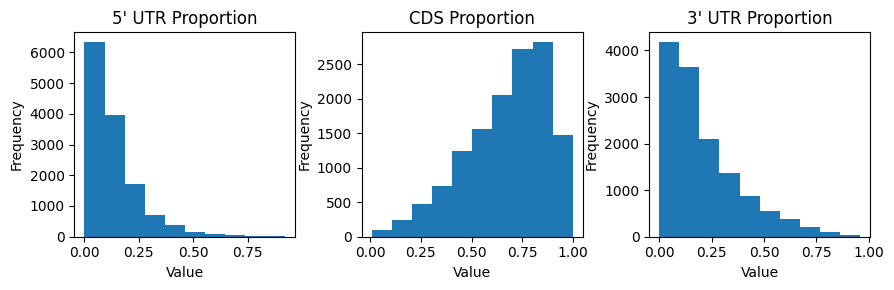

In [284]:
fig, list_subfig = plt.subplots(1, 3, figsize = (9,3))

# 5' UTR Proportion
list_subfig[0].hist(x = UTR_5_proportion)
list_subfig[0].set_title("5' UTR Proportion")
list_subfig[0].set_xlabel("Value")
list_subfig[0].set_ylabel("Frequency")

# CDS Proportion
list_subfig[1].hist(x = CDS_proportion)
list_subfig[1].set_title("CDS Proportion")
list_subfig[1].set_xlabel("Value")
list_subfig[1].set_ylabel("Frequency")

# 3' UTR Proportion
list_subfig[2].hist(x = UTR_3_proportion)
list_subfig[2].set_title("3' UTR Proportion")
list_subfig[2].set_xlabel("Value")
list_subfig[2].set_ylabel("Frequency")

# The tight layout option ensures that the axes are not overlapping
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)  # Adjust the value as needed

plt.show()

Overall, it looks like the proportion of the total transcript that includes the 5' UTR, and the proportion of the 3' UTR, are both skewed to the right, while the CDS proportion is skewed to the left. These proportions may also impact the frequency of intron retention events within these regions, which I hope to explore in future analysis.

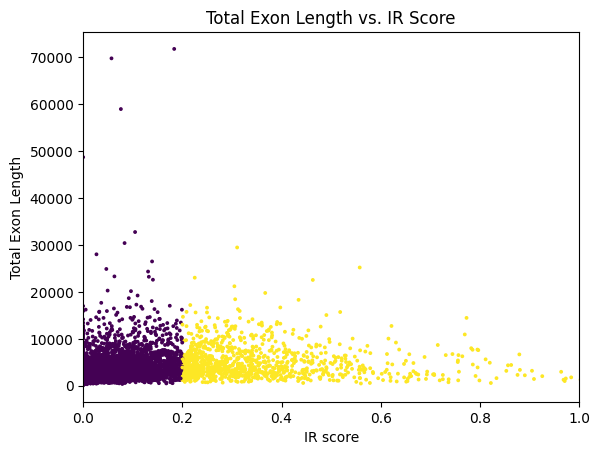

In [285]:
# Generate scatter plot of intron retention score vs. transcript length (total length of exons)
IR_score = rpkm_all_features["IR Score"]
spliced_length = rpkm_all_features["Exon Length"]

plt.scatter(y = spliced_length, x = IR_score, s=3, c = rpkm_all_features['Intron Retention'])
plt.xlabel("IR score")
plt.ylabel("Total Exon Length")
plt.xlim(0,1)
plt.title("Total Exon Length vs. IR Score")
plt.show()

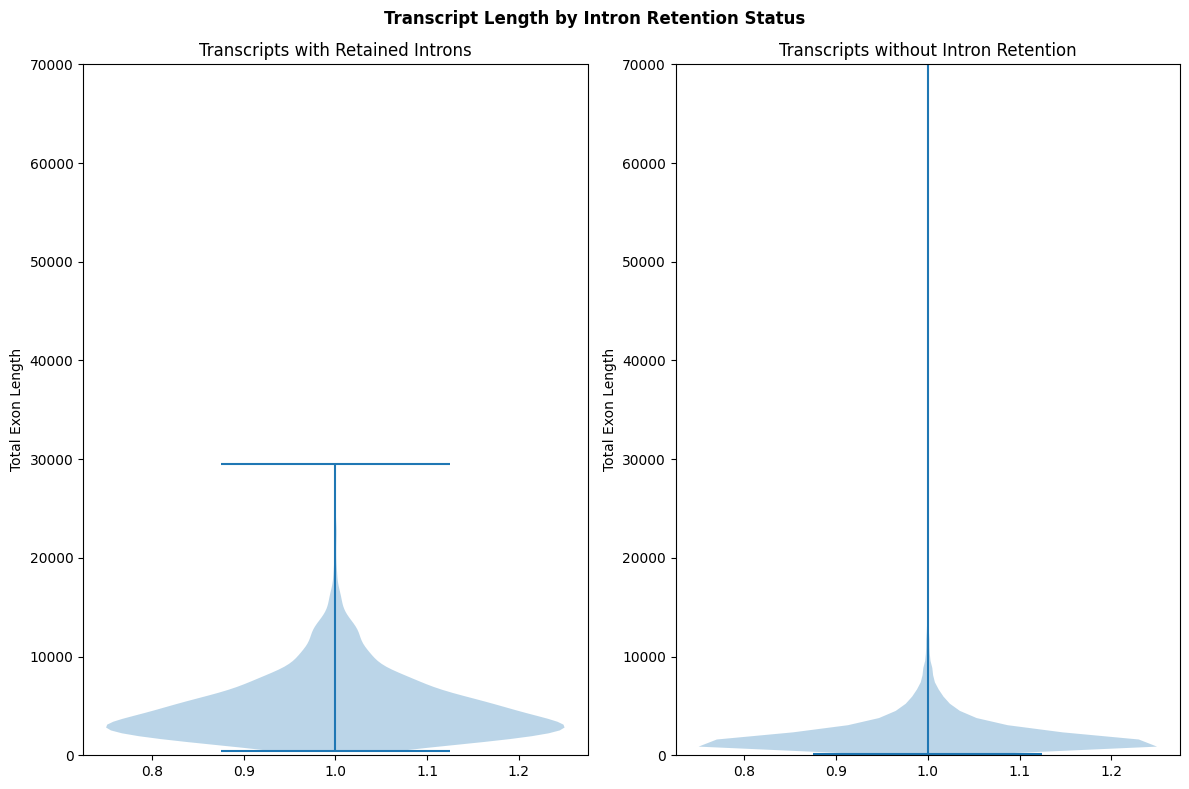

In [286]:
# Generate violin plots of total exon lengths for intron retention events and transcripts without them 
fig, list_subfig = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

list_subfig[0].violinplot(retained_spliced_length)
list_subfig[0].set_ylabel("Total Exon Length")
list_subfig[0].set_ylim(0,70000)
list_subfig[0].set_title("Transcripts with Retained Introns")

list_subfig[1].violinplot(low_IR_length)
list_subfig[1].set_ylabel("Total Exon Length") 
list_subfig[1].set_ylim(0,70000)
list_subfig[1].set_title("Transcripts without Intron Retention") 
# The tight layout option ensures that the axes are not overlapping

plt.suptitle("Transcript Length by Intron Retention Status",fontweight='bold')
plt.tight_layout()

plt.show()

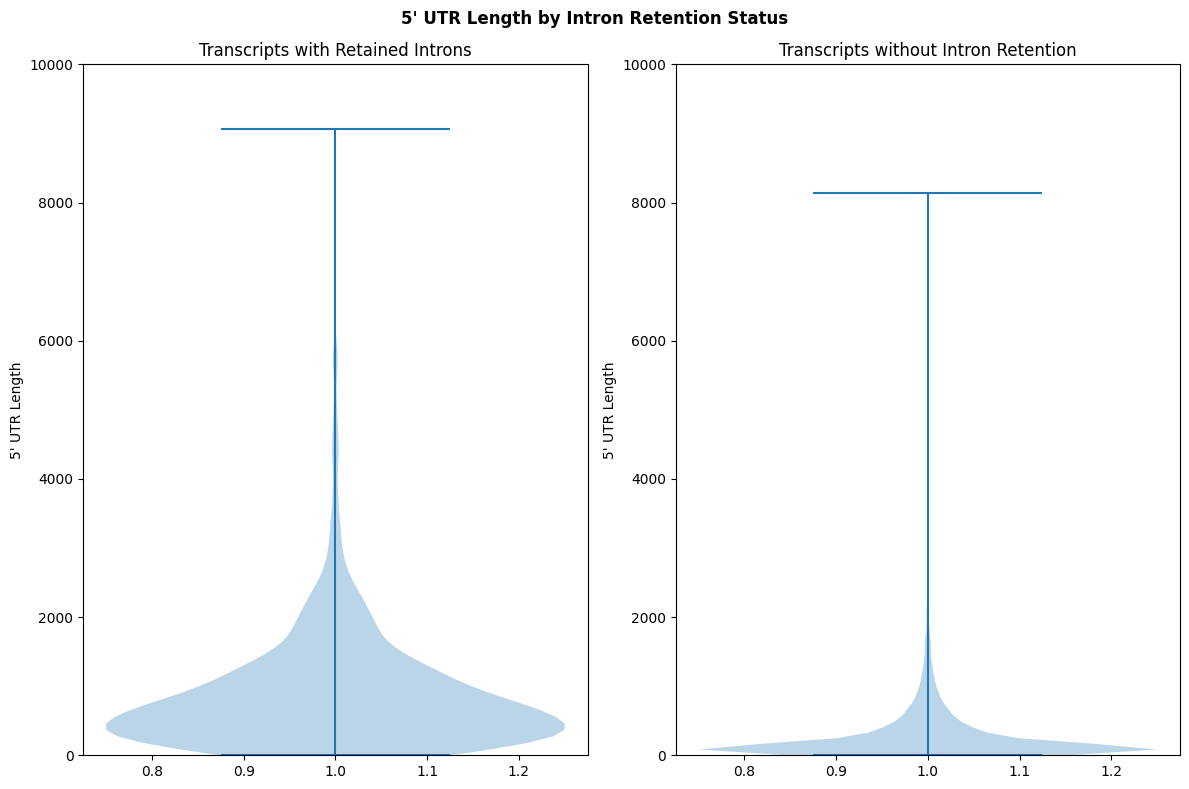

count    12307.000000
mean       297.381978
std        451.139459
min          1.000000
25%         71.000000
50%        132.000000
75%        347.000000
max       8140.000000
Name: 5' UTR Length, dtype: float64

In [287]:
IR_length = retained_intron_genes["5' UTR Length"]
without_IR_length = genes_without_IR["5' UTR Length"]

# Generate violin plots of total gene RPKM for transcripts with intron retention events and transcripts without them 
fig2, list_subfig2 = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

list_subfig2[0].violinplot(IR_length)
list_subfig2[0].set_ylabel("5' UTR Length")
list_subfig2[0].set_ylim(0,10000)
list_subfig2[0].set_title("Transcripts with Retained Introns")

list_subfig2[1].violinplot(without_IR_length)
list_subfig2[1].set_ylabel("5' UTR Length") 
list_subfig2[1].set_ylim(0,10000)
list_subfig2[1].set_title("Transcripts without Intron Retention") 
# The tight layout option ensures that the axes are not overlapping

plt.suptitle("5' UTR Length by Intron Retention Status",fontweight='bold')
plt.tight_layout()

plt.show() 

IR_length.describe()
without_IR_length.describe()

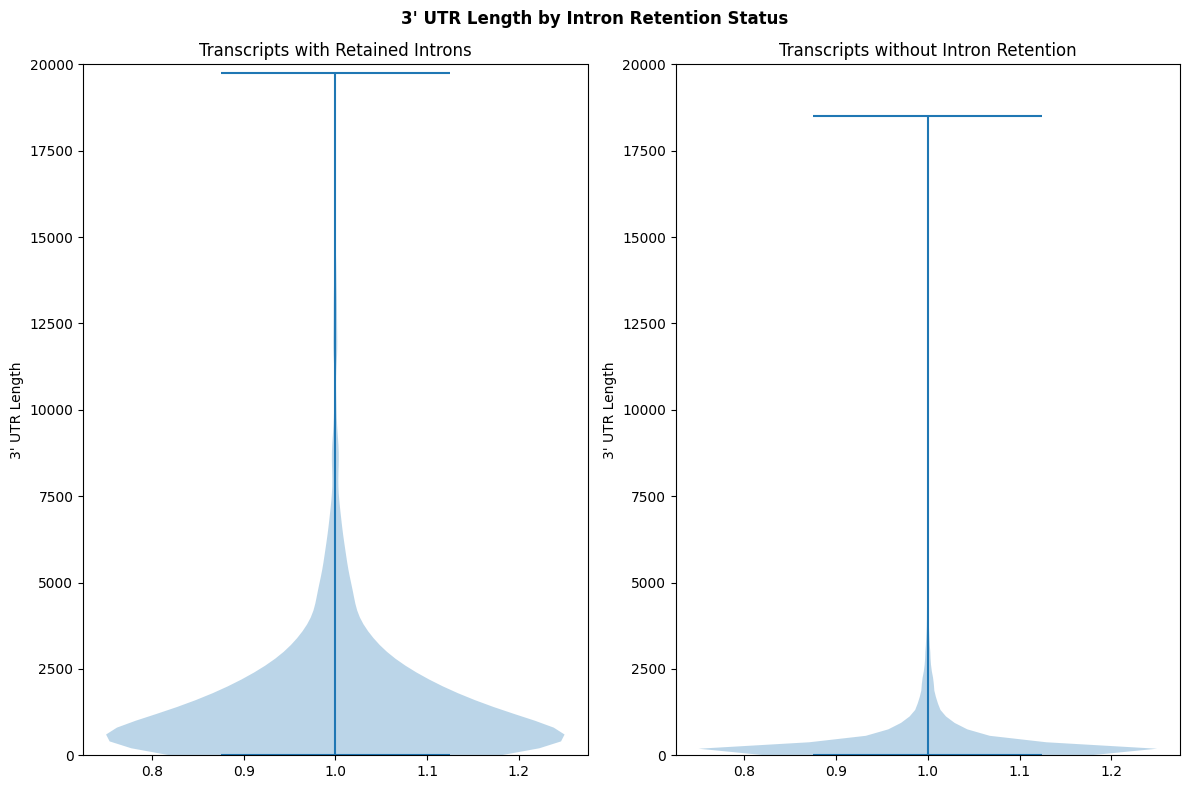

In [288]:
IR_length3 = retained_intron_genes["3' UTR Length"]
without_IR3_length = genes_without_IR["3' UTR Length"]

# Generate violin plots of total gene RPKM for transcripts with intron retention events and transcripts without them 
fig2, list_subfig2 = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

list_subfig2[0].violinplot(IR_length3)
list_subfig2[0].set_ylabel("3' UTR Length")
list_subfig2[0].set_ylim(0,20000)
list_subfig2[0].set_title("Transcripts with Retained Introns")

list_subfig2[1].violinplot(without_IR3_length)
list_subfig2[1].set_ylabel("3' UTR Length") 
list_subfig2[1].set_ylim(0,20000)
list_subfig2[1].set_title("Transcripts without Intron Retention") 
# The tight layout option ensures that the axes are not overlapping

plt.suptitle("3' UTR Length by Intron Retention Status",fontweight='bold')
plt.tight_layout()

plt.show()

### Works Cited: 
1. Jalloh, B., Lancaster, C. L., Rounds, J. C., Brown, B. E., Leung, S. W., Banerjee, A., Morton, D. J., Bienkowski, R. S., Fasken, M. B., Kremsky, I. J., Tegowski, M., Meyer, K., Corbett, A., & Moberg, K. (2023). The Drosophila Nab2 RNA binding protein inhibits m6A methylation and male-specific splicing of Sex lethal transcript in female neuronal tissue. eLife, 12, e64904. https://doi.org/10.7554/eLife.64904
3. Middleton, R., Gao, D., Thomas, A. et al. IRFinder: assessing the impact of intron retention on mammalian gene expression. Genome Biol 18, 51 (2017). https://doi.org/10.1186/s13059-017-1184-4  